In [71]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.manifold import LocallyLinearEmbedding, TSNE, MDS
from sklearn.ensemble import RandomForestClassifier

In [2]:
X = np.random.randn(100, 100)
X_centered = X - X.mean(axis=0)

u, s, vh = np.linalg.svd(X_centered)

c1 = vh.T[:, 0]
c2 = vh.T[:, 1]

In [3]:
sum(map(lambda x: x**2, u[0, :]))**0.5

1.0000000000000002

In [4]:
vh.shape

(100, 100)

In [5]:
X2D = X_centered.dot(vh.T[:, :2])
X2D[:5]

array([[-3.82597581,  0.07261898],
       [-2.57736537, -2.32260878],
       [-0.83080625, -1.55322938],
       [-0.51865968,  0.18287524],
       [-2.73468151, -0.8802456 ]])

In [6]:
pca = PCA(50)
X2D = pca.fit_transform(X)

In [7]:
pca.components_.shape

(50, 100)

In [8]:
pca.explained_variance_ratio_

array([0.03654773, 0.03507269, 0.0348647 , 0.03189689, 0.03107487,
       0.03034669, 0.02952332, 0.02895963, 0.02771377, 0.026931  ,
       0.02677655, 0.02533887, 0.02472697, 0.02398801, 0.02337647,
       0.02239849, 0.02118022, 0.02069971, 0.02058397, 0.01913548,
       0.01896114, 0.01815847, 0.01743317, 0.01684452, 0.01636594,
       0.01595133, 0.01542128, 0.01462836, 0.014272  , 0.01384837,
       0.01338469, 0.01259916, 0.01231664, 0.01203996, 0.01154303,
       0.01148759, 0.01087213, 0.01043975, 0.01029678, 0.00997728,
       0.00955457, 0.00909352, 0.00866384, 0.00815658, 0.00772786,
       0.00767039, 0.00743666, 0.00725846, 0.00702556, 0.00650851])

In [9]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
len(pca.explained_variance_ratio_[cumsum<=0.50])

17

In [10]:
np.argmax(cumsum>0.50)

17

In [11]:
sum(cumsum<=0.50)

17

In [12]:
pca = PCA(n_components=0.95)
X2D = pca.fit_transform(X)
len(pca.components_)

61

<class 'numpy.ndarray'>
(333, 333, 3)


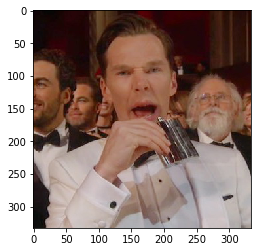

In [13]:
mat = im.imread('img/31KLTJA28_Y_av.jpg')
print(type(mat))
print(mat.shape)
plt.imshow(mat)
plt.show()

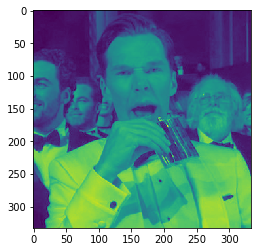

In [14]:
mat_bw = mat.mean(axis=2)
plt.imshow(mat_bw)

n_components: 22


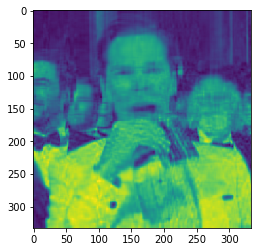

In [15]:
pca = PCA(0.98)
mat_bw_transformed = pca.fit_transform(mat_bw)
print("n_components: %d" % len(pca.components_))
plt.imshow(pca.inverse_transform(mat_bw_transformed))
plt.show()

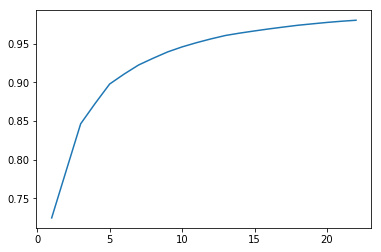

In [16]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(np.arange(len(cumsum))+1, cumsum)
plt.show()

### Incremental PCA

In [2]:
mnist = fetch_mldata('MNIST original')
X_train, X_test, y_train, y_test =train_test_split(mnist['data'], mnist['target'], test_size=10000)

In [45]:
n_batches = 10
inc_pca = IncrementalPCA(n_components=49)
for X_batch in np.array_split(X_train[:1000], n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)    

In [46]:
fname = 'datasets/mnist_data_1000.pkl'
X_train[:1000].dump(fname)

In [47]:
X_train[:1000].shape

(1000, 784)

In [48]:
X_mm = np.memmap(fname, dtype='uint8', mode='readonly', shape=(1000, 784))
batch_size = 784 * 10
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=7840, copy=True, n_components=154, whiten=False)

### Randomized PCA

In [49]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

### Kernel PCA

In [50]:
rbf_pca = KernelPCA(n_components=300, kernel='rbf', gamma=0.04)
mat_bw_reduced = rbf_pca.fit_transform(X_train[:10])
# plt.imshow(rbf_pca.inverse_transform(mat_bw_reduced))

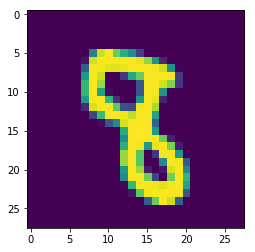

In [51]:
plt.imshow(X_train[0].reshape((28, 28)))
plt.show()

In [69]:
kpca = KernelPCA(n_components=2, kernel='sigmoid')


log_reg = LogisticRegression()
log_reg.fit(kpca.fit_transform(X_train[:500]), y_train[:500])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [78]:
clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['linear', 'rbf']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:600], y_train[:600])

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=1,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRegre...ty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['linear', 'rbf']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
grid_search.best_params_

{'kpca__gamma': 0.03, 'kpca__kernel': 'linear'}

In [82]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X_train[0:1])
X_preimage = rbf_pca.inverse_transform(X_reduced)

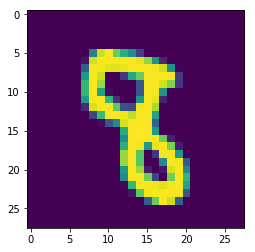

In [89]:
plt.imshow(X_preimage.reshape(28, 28))
plt.show()

In [91]:
mean_squared_error(X_train[0:1], X_preimage)

2198.96237244898

### Locally Linear Embedding 

In [93]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)

### Excercises

In [6]:
%%time
clf = RandomForestClassifier()
clf.fit(X_train, y_train)

Wall time: 4.41 s


In [14]:
%%time
accuracy_score(y_test, clf.predict(X_test))

Wall time: 68 ms


0.95

In [8]:
pca = PCA(0.95)
X_train_095 = pca.fit_transform(X_train)
X_test_095 = pca.transform(X_test)

In [10]:
%%time
clf_095 = RandomForestClassifier()
clf_095.fit(X_train_095, y_train)

Wall time: 9.05 s


In [12]:
%%time
accuracy_score(y_test, clf_095.predict(X_test_095))

Wall time: 31 ms


0.8885

In [73]:
def plot_digit(ax, mat, xy):
    imagebox = OffsetImage(mat, zoom=0.85)
    imagebox.image.axes = ax   

    ab = AnnotationBbox(imagebox, xy=xy, box_alignment=(0.5, 0.5), frameon=False)
    ax.add_artist(ab)
    
def plot_embeddings(X_, y_):
    colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'w', 'orange', 'purple'
 
    fig, ax = plt.subplots(figsize=(10, 10))

    for i, c, label in zip(range(10), colors, range(10)):
        x_coords = X_[y_ == i, 0]
        y_coords = X_[y_ == i, 1]

        ax.scatter(x_coords, y_coords, c=c, label=label)

        x_mean = np.mean(x_coords)
        y_mean = np.mean(y_coords)
        mat = X_train[:1000][y_ == i][0].reshape((28, 28))

        plot_digit(ax, mat, (x_mean, y_mean))


    ax.legend(loc="best")
    ax.legend_.remove()
    plt.show()

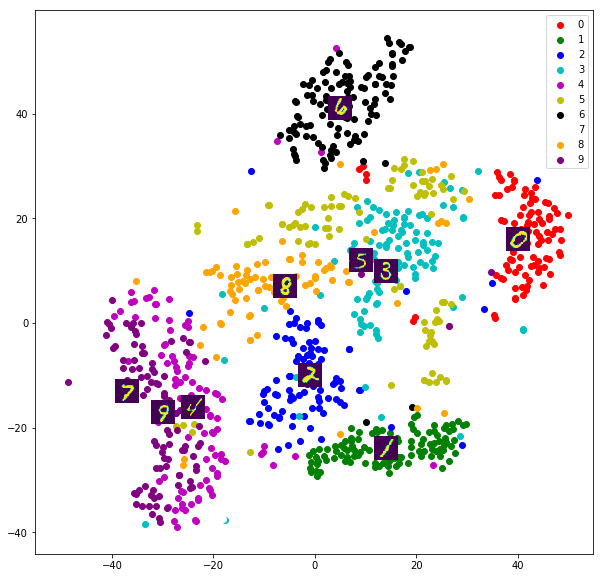

In [66]:
tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(X_train[:1000])
plot_embeddings(X_embedded, y_train[:1000])

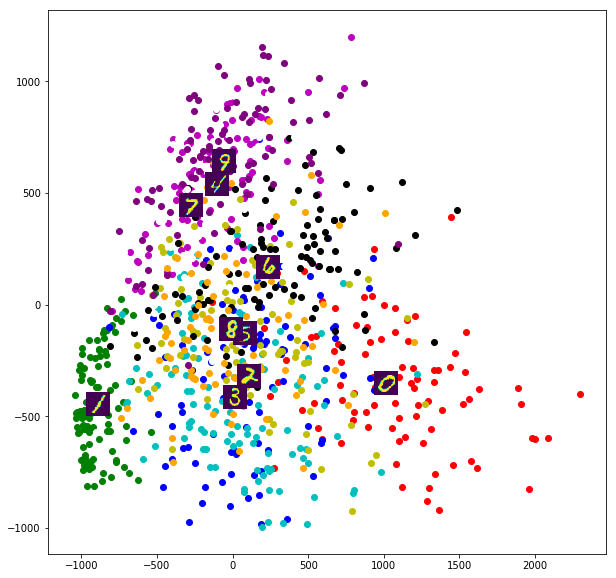

In [74]:
pca = PCA(n_components=2)
X_embedded = pca.fit_transform(X_train[:1000])
plot_embeddings(X_embedded, y_train[:1000])

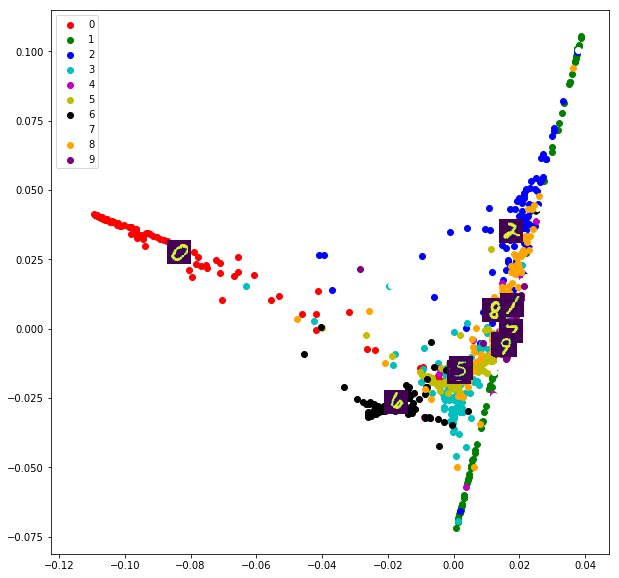

In [70]:
lle = LocallyLinearEmbedding(n_components=2)
X_embedded = lle.fit_transform(X_train[:1000])
plot_embeddings(X_embedded, y_train[:1000])

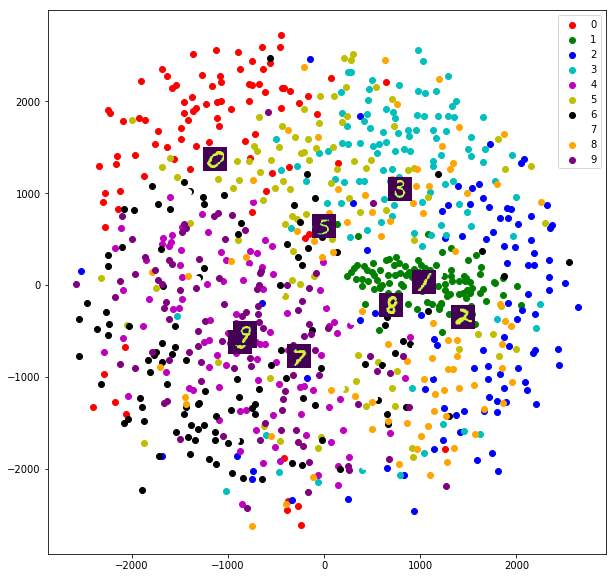

In [72]:
mds = MDS(n_components=2)
X_embedded = mds.fit_transform(X_train[:1000])
plot_embeddings(X_embedded, y_train[:1000])